In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import cvxpy as cp
from prettytable import PrettyTable


In [25]:
Montante = 20000 # montante inicial
Taxa_min = 0.5 # taxa mínima de retorno

# selecionando as empresas que serão analisadas
companies = ['PETR4.SA', 'BBAS3.SA', 'VALE3.SA', 'EMBR3.SA', 'ABEV3.SA']

companies.sort()


In [4]:
# selecionando o período de análise: 3 anos
end_date = datetime.datetime(2024, 10, 5)
start_date = end_date - datetime.timedelta(weeks=4*52)

data = yf.download(companies, start=start_date, end=end_date, interval='1wk')
closing_prices = data['Close'].resample('W-FRI').last() # selecionando o preço de fechamento de cada sexta-feira


[*********************100%***********************]  5 of 5 completed


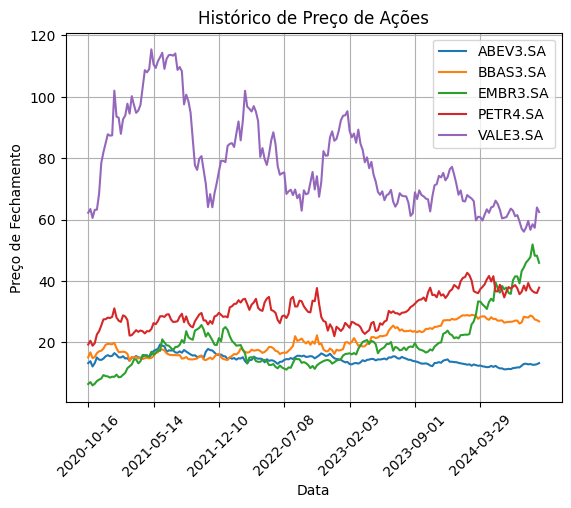

In [5]:
for coluna in closing_prices.columns:
    plt.plot(closing_prices.index, closing_prices[coluna], label=coluna)
    
plt.xticks(closing_prices.index[::15*6 // 3], rotation=45)
    
plt.title('Histórico de Preço de Ações')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)

# Mostra o gráfico
plt.show()

In [6]:
# calculando a taxa de retorno a cada semana
taxas_retornos = 100 * closing_prices.pct_change().dropna()

# calculando a média das taxas de cada empresa a fim de estimar a taxa de retorno esperada
taxas_retornos_medias = taxas_retornos.mean()

print(taxas_retornos_medias)
print(taxas_retornos_medias.values)


Ticker
ABEV3.SA    0.064609
BBAS3.SA    0.362486
EMBR3.SA    1.164027
PETR4.SA    0.471514
VALE3.SA    0.111073
dtype: float64
[0.06460938 0.36248576 1.16402739 0.47151361 0.11107336]


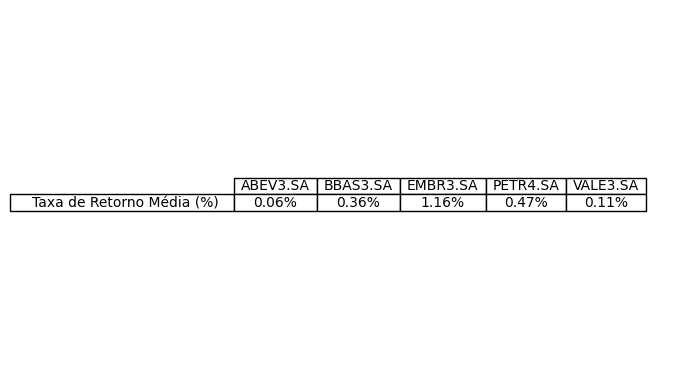

In [7]:
def create_table(cellText, colLabels, rowLabels):
    
    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=cellText,
                    colLabels=colLabels,
                    rowLabels=rowLabels,
                    loc='center',
                    cellLoc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(taxas_retornos_medias.index))))

    plt.show()

create_table([taxas_retornos_medias.map('{:.2f}%'.format).values], 
             taxas_retornos_medias.index, 
             ['Taxa de Retorno Média (%)'])

    


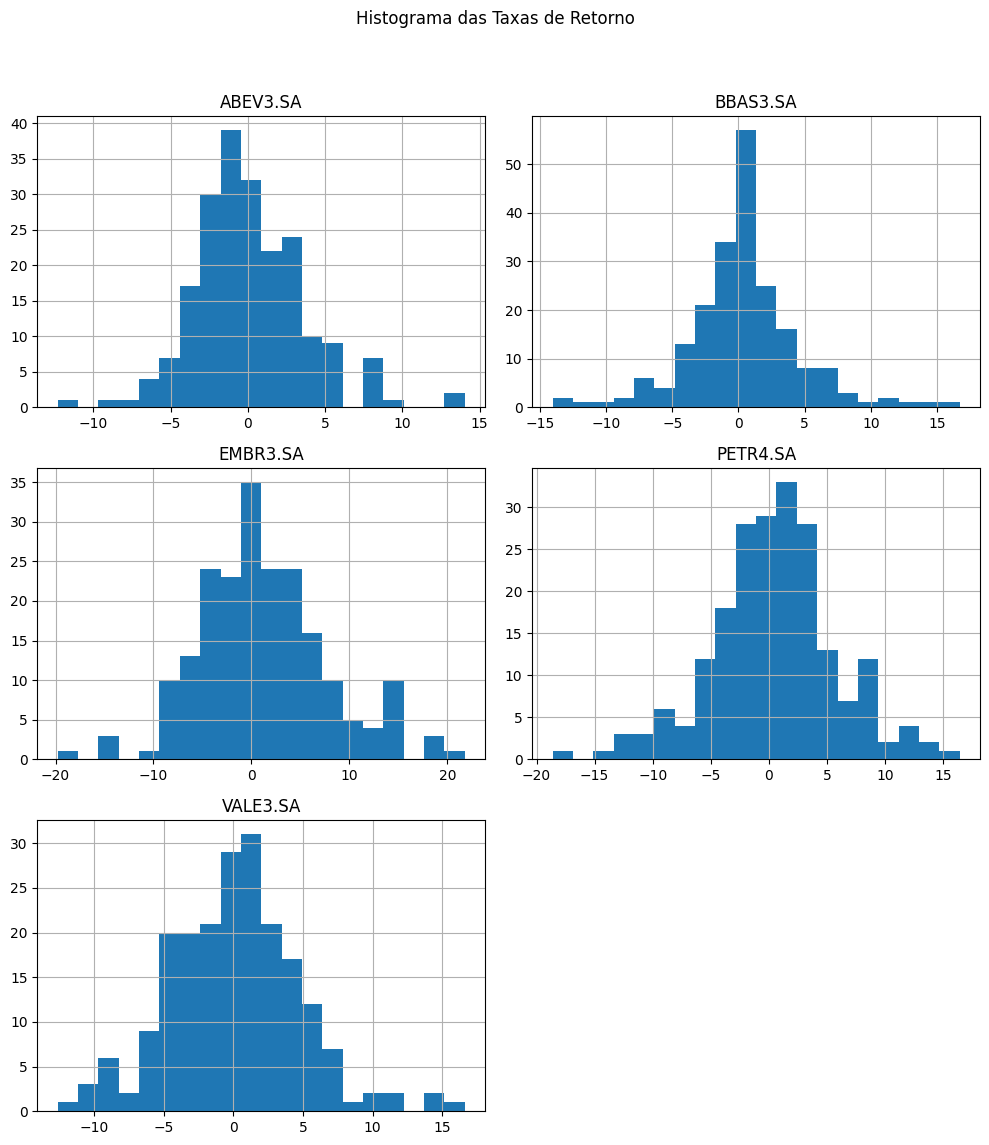

In [8]:
taxas_retornos.hist(bins=20, figsize=(10, 12), layout=(3, 2))
plt.suptitle('Histograma das Taxas de Retorno')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Modelo de Markowitz

A partir daqui iremos resolver o problema utilizando o modelo de Markowitz

1. Cálculo dos retornos medios das companhias escolhidas.
2. Cálculo da covariância entre os seus retornos diários.
3. Resolução de um problema de Programação quadratica
4. Determinação da carteira.

In [9]:
retorno_cov = taxas_retornos.cov()
print(retorno_cov)


# matriz de covariância
Sigma = np.array(retorno_cov)

Ticker     ABEV3.SA   BBAS3.SA   EMBR3.SA   PETR4.SA   VALE3.SA
Ticker                                                         
ABEV3.SA  13.043390   5.845094   5.253934   3.388338   0.966045
BBAS3.SA   5.845094  17.157574   4.383025  11.598043   3.219101
EMBR3.SA   5.253934   4.383025  43.603388   2.360573   4.516157
PETR4.SA   3.388338  11.598043   2.360573  29.291808   5.969634
VALE3.SA   0.966045   3.219101   4.516157   5.969634  22.093171


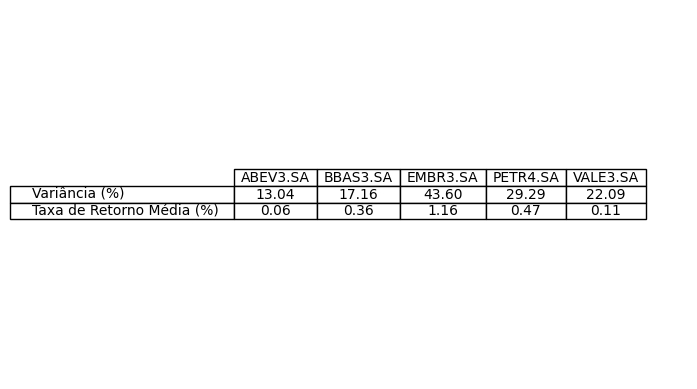

In [10]:
variances = np.diag(Sigma)

create_table([list(map('{:.2f}'.format, variances)), taxas_retornos_medias.map('{:.2f}'.format).values],
             companies,
             ['Variância (%)', 'Taxa de Retorno Média (%)'])


In [11]:
# número de empresas
n = len(companies)

# variáveis de decisão
x = cp.Variable(n)

In [26]:
# função objetivo
objetivo = cp.Minimize(cp.quad_form(x, Sigma))

# retornos médios esperados
r = np.array(taxas_retornos_medias)

# restrições
restricoes = [
    cp.sum(x) == 1,
    r @ x >= Taxa_min,
    x <= 1,
    x >= 0
]

problema_markowitz = cp.Problem(objetivo, restricoes)
problema_markowitz.solve()
#if (problema_markowitz.status == cp.OPTIMAL):
#    print("Pesos ótimos:", x.value, np.sqrt(problema_markowitz.value), r @ x.value)
#else:
#    print("Problema não resolvido\nstatus: ", problema_markowitz.status)

np.float64(9.554782036589115)

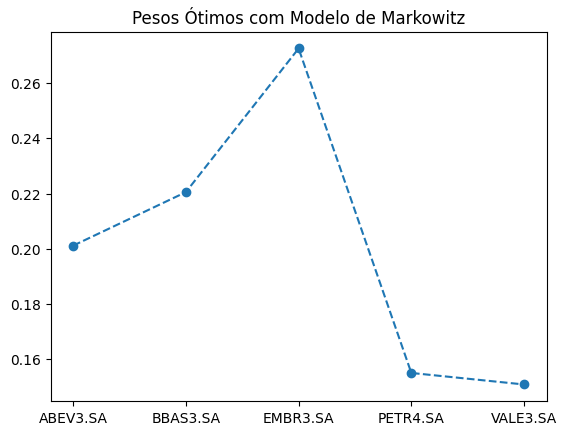

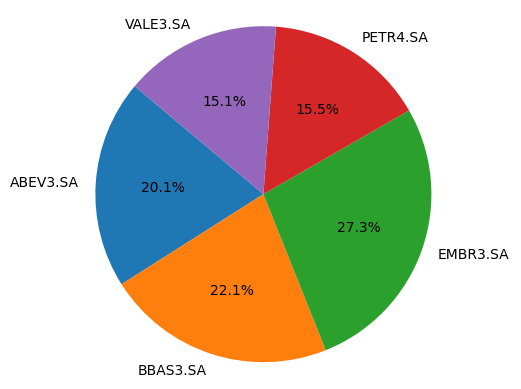

In [27]:
if (problema_markowitz.status == cp.OPTIMAL):
    plt.plot(companies, x.value,  '--o')
    plt.title('Pesos Ótimos com Modelo de Markowitz')
    plt.show()
    
    # Remove weights that are too small to impact the graphic
    threshold = 0.01
    filtered_weights = np.where(x.value <= threshold, 0, x.value)
    filtered_companies = [companies[i] for i in range(len(companies)) if filtered_weights[i] > 0]

    plt.pie(filtered_weights[filtered_weights > 0], labels=filtered_companies, autopct='%1.1f%%', startangle=140)
    #plt.title('Distribuição dos Pesos Ótimos com Modelo de Markowitz (Filtrado)')
    plt.axis('equal')
    plt.show()

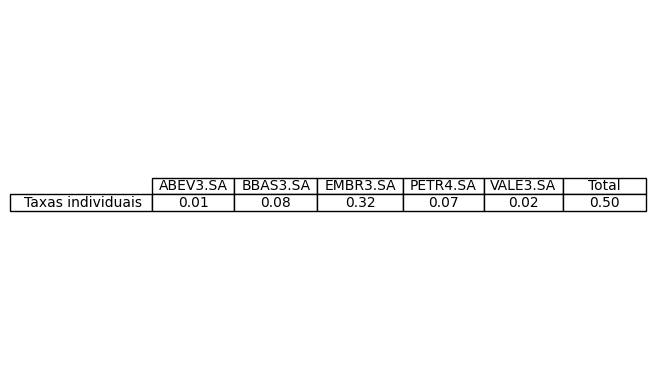

In [28]:
taxas_individuais_markowitz = list(map(lambda x, y: x*y, r, x.value))

taxas_individuais_markowitz.append(sum(taxas_individuais_markowitz))

create_table([list(map('{:.2f}'.format, taxas_individuais_markowitz))],
              companies+['Total'], 
              ['Taxas individuais'])

# Modelo de Konno-Yamazaki

1. Cálculo dos retornos médios das companhias escolhidas.
2. Cálculo do desvio do rendimento do título j no momento t face ao rendimento
médio do título j.
3. Resolução de um problema de Programação Linear
4. Determinação da carteira.

In [29]:
desvios_absolutos_taxas_retornos = (taxas_retornos - taxas_retornos_medias).abs().mean()

print(desvios_absolutos_taxas_retornos)

a = np.array(desvios_absolutos_taxas_retornos)

Ticker
ABEV3.SA    2.717202
BBAS3.SA    2.857892
EMBR3.SA    5.049536
PETR4.SA    4.095170
VALE3.SA    3.607717
dtype: float64


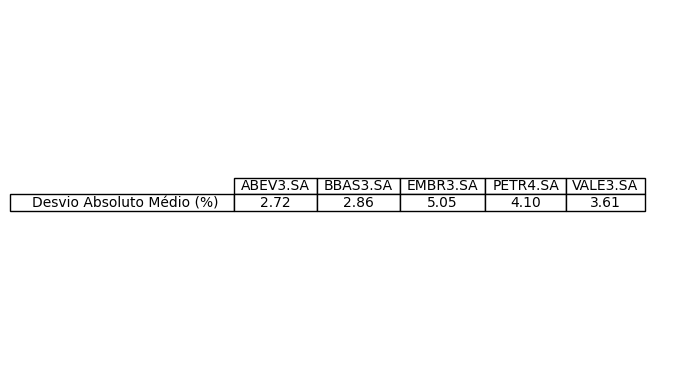

In [30]:

create_table([desvios_absolutos_taxas_retornos.map('{:.2f}'.format).values],
              companies, 
              ['Desvio Absoluto Médio (%)'])


In [31]:
y = cp.Variable(n)

objetivo = cp.Minimize(a @ y)

restricoes = [
    cp.sum(y) == 1,
    r @ y >= Taxa_min,
    y >= 0 
]

problema_konno = cp.Problem(objetivo, restricoes)
problema_konno.solve()

#if (problema_konno.status == cp.OPTIMAL):
#    print("Pesos ótimos:", y.value, problema_konno.value, r @ y.value)
#else:
#    print("Problema não resolvido\nstatus: ", problema_konno.status)

np.float64(3.2338952358461985)

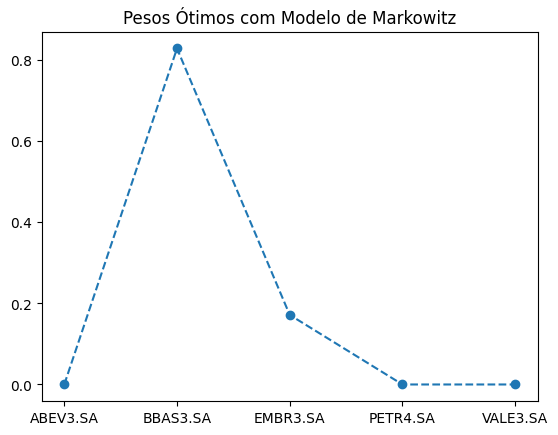

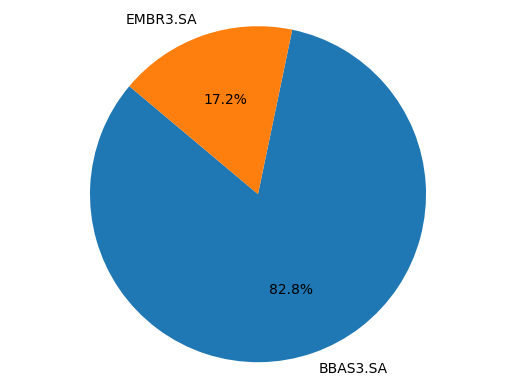

In [32]:
if (problema_konno.status == cp.OPTIMAL):
    plt.plot(companies, y.value,  '--o')
    plt.title('Pesos Ótimos com Modelo de Markowitz')
    plt.show()
    
    # Remove weights that are too small to impact the graphic
    threshold = 0.01
    filtered_weights = np.where(y.value <= threshold, 0, y.value)
    filtered_companies = [companies[i] for i in range(len(companies)) if filtered_weights[i] > 0]

    plt.pie(filtered_weights[filtered_weights > 0], labels=filtered_companies, autopct='%1.1f%%', startangle=140)
    #plt.title('Distribuição dos Pesos Ótimos com Modelo de Markowitz (Filtrado)')
    plt.axis('equal')
    plt.show()

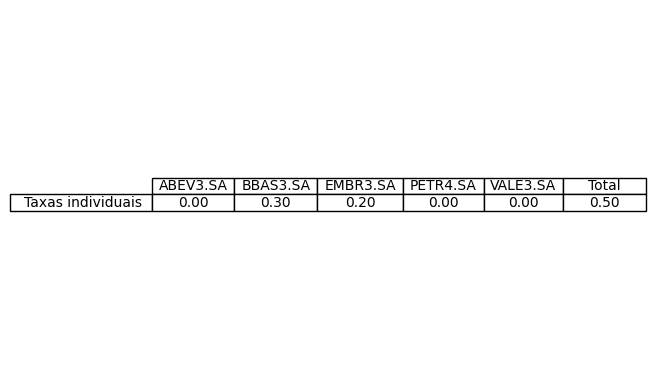

In [33]:
taxas_individuais_konno = list(map(lambda x, y: x*y, r, np.abs(y.value)))

taxas_individuais_konno.append(np.sum(taxas_individuais_konno))

create_table([list(map('{:.2f}'.format, taxas_individuais_konno))],
              companies+['Total'], 
              ['Taxas individuais'])

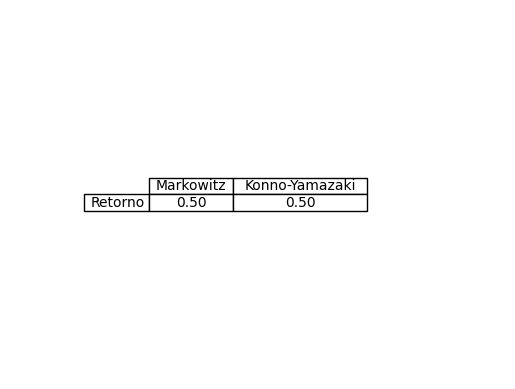

In [34]:

cellText = [
    list(map('{:.2f}'.format, [r @ x.value, r @ y.value])),
]

create_table(cellText, ['Markowitz', 'Konno-Yamazaki'], ['Retorno'])

# Previsões

o Objetivo aqui é pegar os dados, fazer previsões e comparar

In [35]:
new_end_date = datetime.datetime(2024, 11, 9)
start_date = end_date

comparative_data = yf.download(companies, start=start_date, end=new_end_date, interval="1wk")
comparative_closing_prices = comparative_data['Close'].resample('W-FRI').last()

#print(comparative_closing_prices)

[*********************100%***********************]  5 of 5 completed


In [36]:
comparative_taxas_medias = 100 * comparative_closing_prices.pct_change().dropna().mean()

print(comparative_taxas_medias)

prod1 = np.array(comparative_taxas_medias) @ x.value
prod2 = np.array(comparative_taxas_medias) @ y.value

print(prod1, prod2)

Ticker
ABEV3.SA   -1.082755
BBAS3.SA   -0.319198
EMBR3.SA    4.455563
PETR4.SA   -0.954987
VALE3.SA   -0.591309
dtype: float64
0.6889051209085685 0.4999705497637317


/home/john/Projects/Faculdade/Otimizacao/TrabalhoFinal/lib/python3.12/site-packages/matplotlib/table.py:808: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text=cellText[row][col],


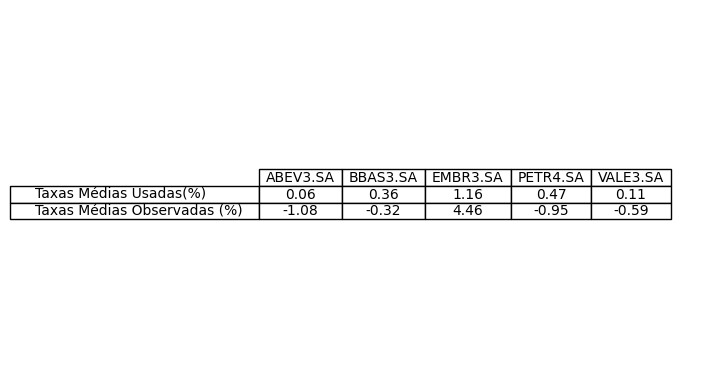

In [37]:
create_table([taxas_retornos_medias.apply(lambda x: f"{x:.2f}"), comparative_taxas_medias.apply(lambda x: f"{x:.2f}")],
              companies,
              ['Taxas Médias Usadas(%)', 'Taxas Médias Observadas (%)']
             )


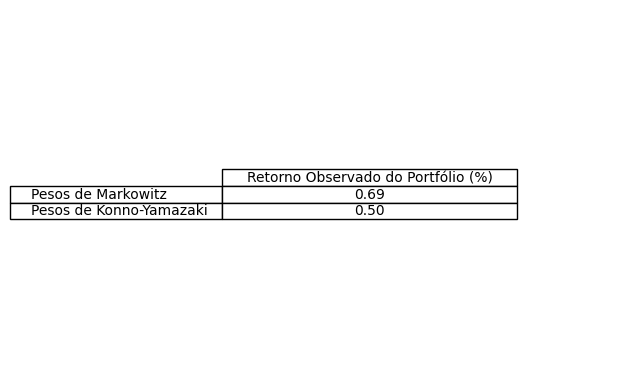

In [38]:
create_table([[f'{prod1:.2f}'], [f'{prod2:.2f}']],
             ["Retorno Observado do Portfólio (%)"],
             ["Pesos de Markowitz", "Pesos de Konno-Yamazaki"])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 

(array([3.000e+00, 6.000e+00, 1.500e+01, 3.500e+01, 8.100e+01, 1.900e+02,
        4.450e+02, 1.044e+03, 2.446e+03, 5.733e+03]),
 array([0.69314718, 1.5448565 , 2.39656582, 3.24827514, 4.09998446,
        4.95169377, 5.80340309, 6.65511241, 7.50682173, 8.35853105,
        9.21024037]),
 <BarContainer object of 10 artists>)

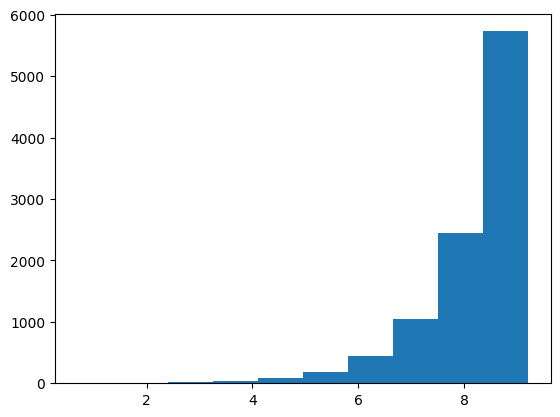

In [11]:
k = list(range(2, 10000))
print(k)
f = lambda x: np.log(x)

plt.hist(list(map(f, k)))